In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
SEED = 42

In [3]:
DATA_PATH = '../data/archive.zip'

## Data Processing

In [4]:
raw_df = pd.read_csv(DATA_PATH)

In [5]:
raw_df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


Let's see how clean our data is.

In [6]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


All columns are continuous (numerical). There are no missing values.  

Let's check for duplicates.

In [7]:
raw_df.duplicated().sum()

25

In [8]:
raw_df.drop_duplicates(inplace=True)

Looks like there is no need to clean, delete or replace data.

## EDA

There is a controversy about whether to do EDA on the entire dataset or only training part of it.

In my opinion, as long as we do not use the information from EDA to decide which model to use, to tweak parameters, and so forth we can do EDA on the entire dataset.

Once we start using the information from the analysis for any change in the data, or make any desicion about model building, we have to switch to the training part



Let's look at the distribution of the data.

In [9]:
raw_df.describe()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
count,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000
mean,278.631343,72.043483,55.536318,182.075323,6.033234,974.376816,772.688259,45.856716,35.250378
std,104.344261,86.170807,64.207969,21.339334,5.919967,77.579667,80.340435,63.734692,16.284815
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,190.700000,0.000000,0.000000,166.600000,0.000000,932.000000,724.300000,7.000000,23.520000
50%,265.000000,20.000000,0.000000,185.700000,6.100000,968.000000,780.000000,28.000000,33.800000
75%,349.000000,142.500000,118.300000,192.900000,10.000000,1031.000000,822.200000,56.000000,44.870000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


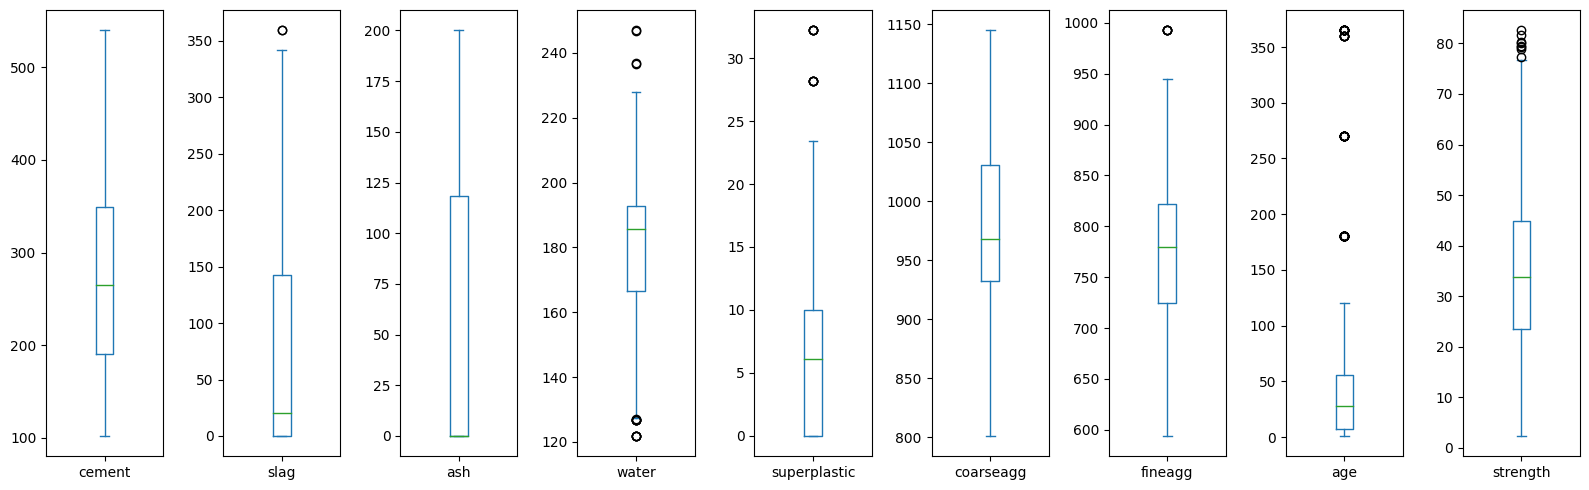

In [10]:
raw_df.plot(kind='box', subplots=True, figsize=[16,5])
plt.tight_layout()

🔴 TODO: mention skewness and outliers

Shouldn't we remove 'age' outliers? Check the number of those.

In [11]:
len(raw_df[raw_df['age'] > 150])

59

The number of these values is quite large and they do not differ significantly from the others. So probably these values are valid.

Let's look at the relationship between the features.

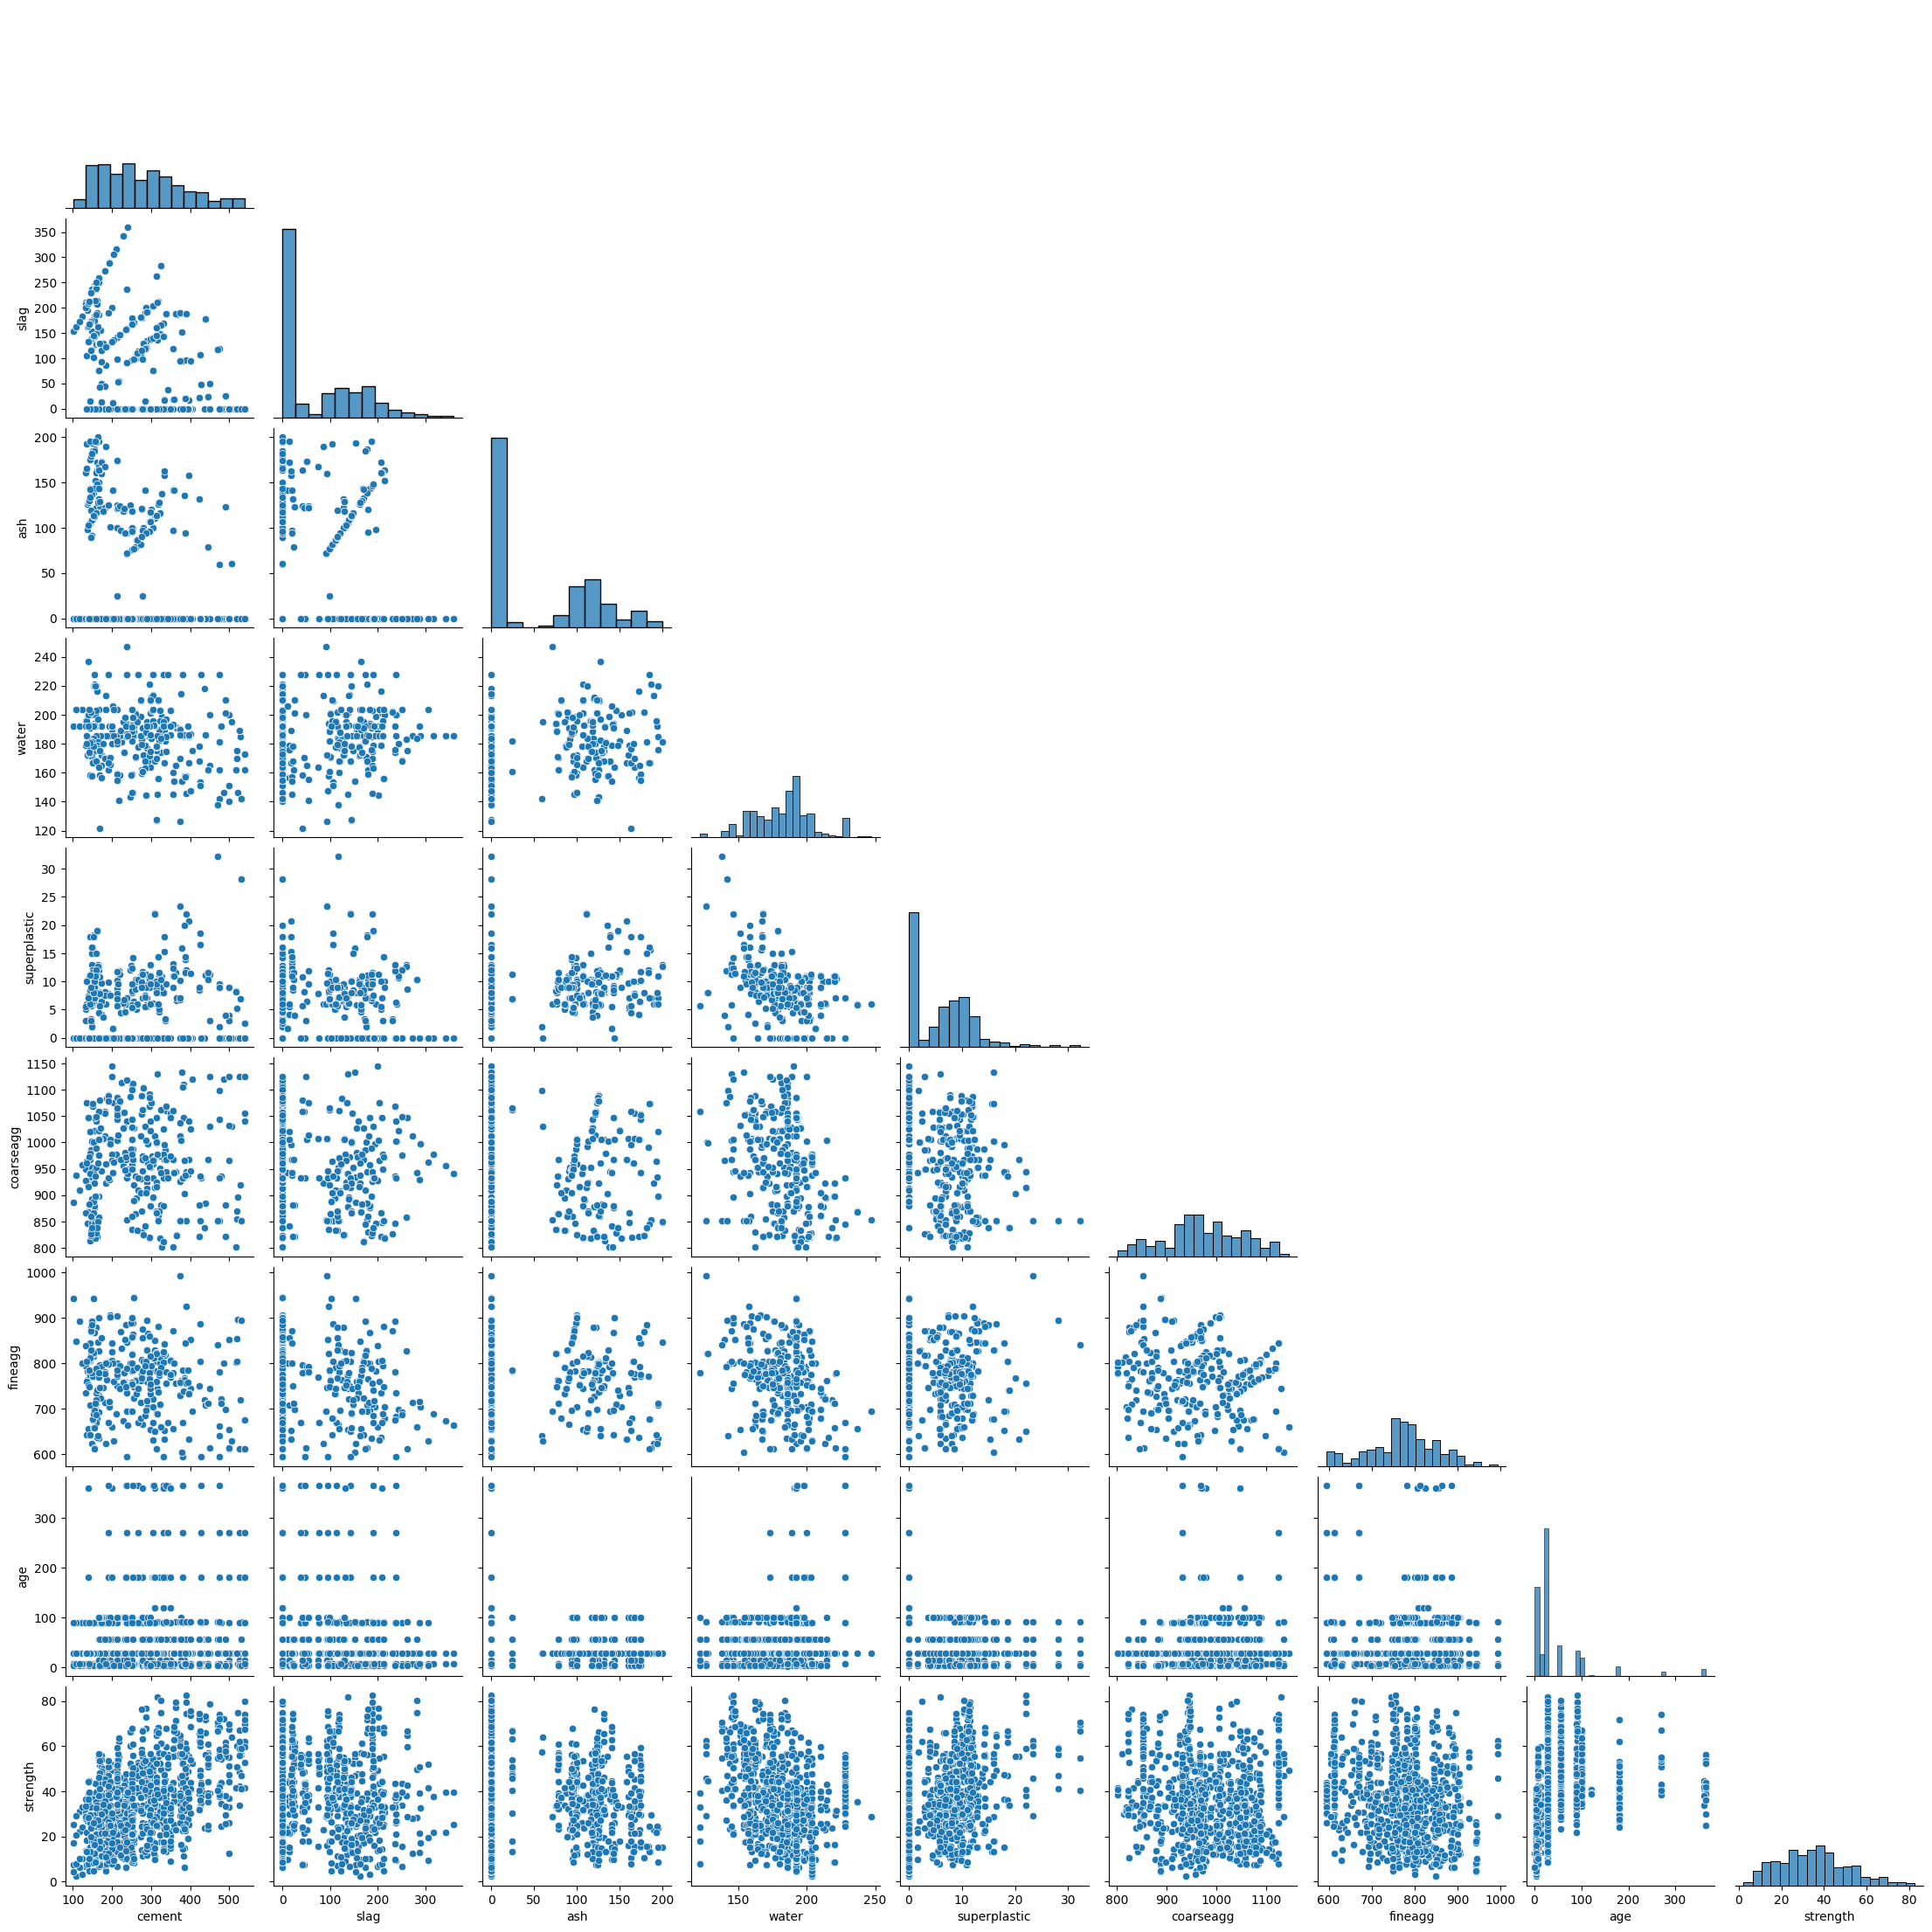

In [12]:
sns.pairplot(raw_df, corner=True);

We do not see any sign of significant correlation between the features. Let's check it numerically.

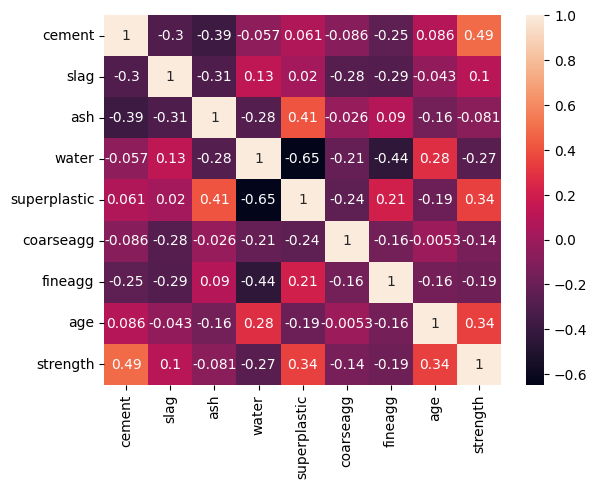

In [13]:
sns.heatmap(raw_df.corr(), annot=True);

Indeed, there is no significant correlation. We may not be concerned about multicollinearity.

Let's look at the distribution of the target variable.

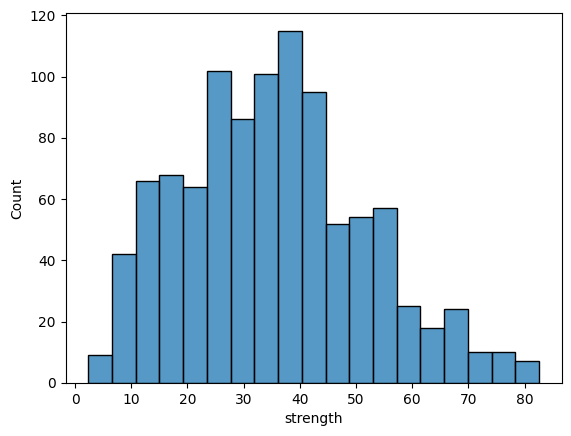

In [14]:
sns.histplot(raw_df['strength']);

The distribution is close to normal. Thus, there is no need to apply any kind of transformation (logarithmic or exponential).

**Bottom line**

As it turns out, our data is clean, complete, and correct. So we had no opportunity to show our abilities in correcting, transforming and filling in the missing values. What a pity!

So let's start modeling.

## Models training

Let's split our data into train, validation, and test sets.

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
df_full_train, df_test = train_test_split(raw_df, test_size=0.2, random_state=SEED)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=SEED)

In [17]:
def prepare_X_y(df, target_col):
    X = df.drop(columns=target_col).values
    y = df[target_col].values
    return X, y

In [18]:
target_col = 'strength'
feature_names = raw_df.columns.drop(target_col)

X_full_train, y_full_train = prepare_X_y(df_train, target_col)
X_train, y_train = prepare_X_y(df_train, target_col)
X_val, y_val = prepare_X_y(df_val, target_col)
X_test, y_test = prepare_X_y(df_test, target_col)

del df_full_train, df_train, df_val, df_test

Our problem is a regression problem. We will use the mean squared error for evauluting the model.

In [19]:
from sklearn.metrics import mean_squared_error

Let's create a helper function to score the model.

In [20]:
def score_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    scores = dict()
    y_train_pred = model.predict(X_train)
    scores['train'] = mean_squared_error(y_train, y_train_pred, squared=False)
    y_val_pred = model.predict(X_val)
    scores['val'] = mean_squared_error(y_val, y_val_pred, squared=False)
    return scores

### Linear regression

For Linear regression data should be scaled. We wil use StandardScaler.  
Assemble Linearregression and StandardScaler into one estimator with Pipeline.

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [22]:
lr_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('lr', LinearRegression())]
)

In [23]:
print('RMSE: ', score_model(lr_pipe, X_train, y_train, X_val, y_val))

RMSE:  {'train': 10.00523223631046, 'val': 10.3122081663811}


#### Feature engineering

The concrete compressive strength is a highly nonlinear function of age and ingredients. So Linear regression is not the best choice of the model. But its performance can be improved by adding PolynomialFeatures. Those are features’ high-order and interaction terms. This way we can add complexity to a model.

In [24]:
from sklearn.preprocessing import PolynomialFeatures

In [25]:
lr_poly_pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('poly', PolynomialFeatures()),
    ('lr', LinearRegression())]
)

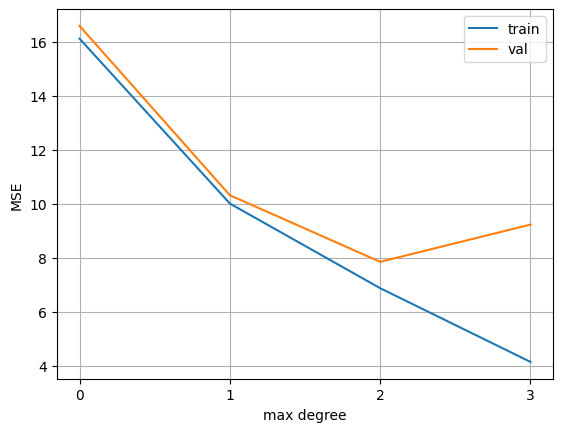

In [26]:
max_degrees = range(4)
scores = []
for degree in max_degrees:
    lr_poly_pipe['poly'].set_params(degree=degree)
    scores.append(score_model(lr_poly_pipe, X_train, y_train, X_val, y_val))
df_scores = pd.DataFrame(scores)
df_scores.plot(
    xticks=max_degrees,
    xlabel='max degree',
    ylabel='MSE',
)
plt.grid() 

Max degree more than 3 leads to a huge increase in the validation error, so we do not consider these values.

Best nodel: max degree = 2  
Re-train the model with this value

In [27]:
lr_poly_pipe['poly'].set_params(degree=2)
lr_poly_pipe.fit(X_train, y_train)
print('RMSE: ', score_model(lr_poly_pipe, X_train, y_train, X_val, y_val))

RMSE:  {'train': 6.8725555263927465, 'val': 7.848223445655855}


### Random forest

In [28]:
from sklearn.ensemble import RandomForestRegressor

In [29]:
rf = RandomForestRegressor(random_state=SEED)

In [30]:
print('RMSE: ', score_model(rf, X_train, y_train, X_val, y_val))

RMSE:  {'train': 2.0398021199592042, 'val': 5.202513412086597}


#### Hyperparameter tuning

Let's create a helper function to tune the model.

In [31]:
def tune_rf(rf, param):
    scores = []
    param_name = param[0]
    param_values = param[1]
    for param_value in param_values:
        rf.set_params(**{param_name: param_value})
        scores.append(score_model(rf, X_train, y_train, X_val, y_val))

    df_scores = pd.DataFrame(scores, index = param_values)
    df_scores.plot(
        title='RMSE', 
        xlabel = param_name,
        figsize=[8, 2])
    plt.grid()
    return df_scores

**Tune max_depth**

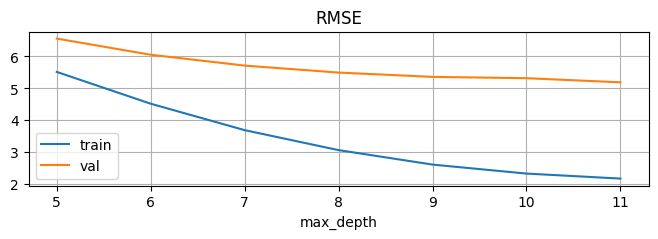

In [32]:
param = ('max_depth', range(5, 12))
tune_rf(rf, param);

In [33]:
rf.set_params(**{'max_depth': 10});

**Tune min_samples_leaf**

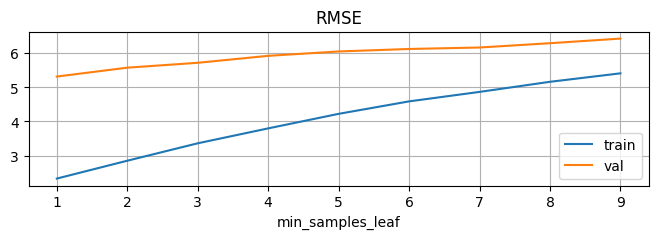

In [34]:
param = ('min_samples_leaf', range(1, 10))
tune_rf(rf, param);

In [35]:
rf.set_params(**{'min_samples_leaf': 1});

**Tune n_estimators**

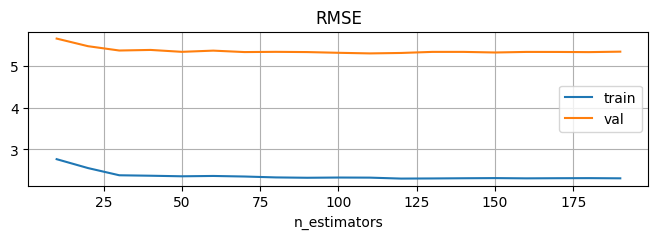

In [36]:
param = ('n_estimators', range(10, 200, 10))
tune_rf(rf, param);

In [37]:
rf.set_params(**{'n_estimators': 30});

In [38]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 10,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 30,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Re-train the model with the best parameters

In [39]:
rf.fit(X_train, y_train)
print('RMSE: ', score_model(rf, X_train, y_train, X_val, y_val))

RMSE:  {'train': 2.379672442797425, 'val': 5.37113431309791}


🔴 TODO:  
Such greedy approach will not necessarily find the best parameters because they are interdependent.  
Try GridSearchCV or RandomSearchCV

### XGBoost

In [40]:
import xgboost as xgb

In [41]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [42]:
xgb_params = {  
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': SEED,
}

In [43]:
evals = [(dtrain, 'train'), (dval, 'val')]
num_boost_round = 100

In [44]:
evals_result = {}
bst = xgb.train(
            params=xgb_params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            evals_result=evals_result,
            verbose_eval=False
        )

In [45]:
print("RMSE: {'train': %s , 'val': %s}" % (evals_result['train']['rmse'][-1], evals_result['val']['rmse'][-1]))

RMSE: {'train': 0.5382524645298726 , 'val': 4.608200537964761}


#### Hyperparameter tuning

Let's create a helper function to tune the booster.

In [46]:
def tune_booster(param):
    scores = {}
    param_name = param[0]
    param_values = param[1]
    for param_value in param_values:
        evals_result = {}
        xgb_params[param_name] = param_value

        bst = xgb.train(
            params=xgb_params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            evals_result=evals_result,
            verbose_eval=False
        )
        scores[f'{param_name} = {param_value}'] = evals_result['val']['rmse']
    
    df_scores = pd.DataFrame(
        scores,
        index = pd.RangeIndex(start=1, stop=num_boost_round + 1, name='iteration')
    )
    print(df_scores.min())    
    df_scores.plot(title='RMSE on validation', figsize=[8, 2])
    plt.grid()

**Tune eta**

eta = 0.3      4.607445
eta = 0.1      4.774635
eta = 0.01    15.916280
dtype: float64


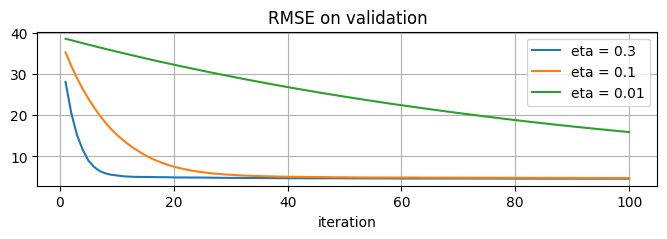

In [47]:
param = ('eta', [0.3, 0.1, 0.01])
tune_booster(param)

In [48]:
xgb_params['eta'] = 0.1

**Tune max_depth**

max_depth = 3    5.221789
max_depth = 4    4.702290
max_depth = 5    4.576847
max_depth = 6    4.774635
dtype: float64


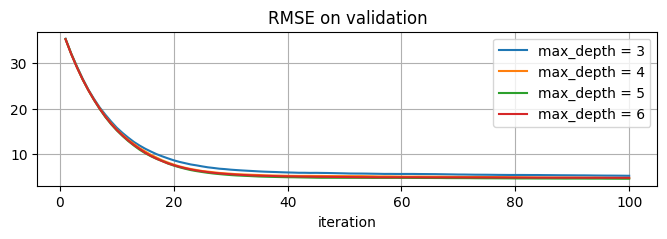

In [49]:
param = ('max_depth', [3, 4, 5, 6])
tune_booster(param)

In [50]:
xgb_params['max_depth'] = 5

**Tune min_child_weight**

min_child_weight = 1     4.576847
min_child_weight = 2     4.516902
min_child_weight = 5     4.703600
min_child_weight = 10    4.875321
min_child_weight = 25    5.222169
min_child_weight = 50    5.760487
dtype: float64


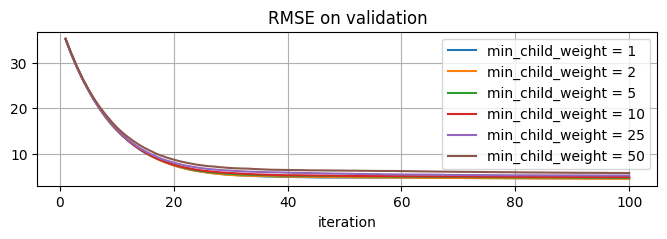

In [51]:
param = ('min_child_weight', [1, 2, 5, 10, 25, 50])
tune_booster(param)

In [52]:
xgb_params['min_child_weight'] = 2

🔴 TODO:  
Such greedy approach will not necessarily find the best parameters because they are interdependent.  
Try GridSearchCV or RandomSearchCV

Re-train the model with the found parameters

In [53]:
evals_result = {}
bst = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=num_boost_round,
    evals=evals,
    evals_result=evals_result,
    verbose_eval=False
)

In [54]:
print("RMSE: {'train': %s , 'val': %s}" % (evals_result['train']['rmse'][-1], evals_result['val']['rmse'][-1]))

RMSE: {'train': 1.9213386737496883 , 'val': 4.516902363059742}


## Model selection

The best of the models is XGBooster.  
Lets retrain it on full_train dataset and test on test dataset.

In [55]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [56]:
xgb_params = {  
    'objective': 'reg:squarederror',
    'eta': 0.1,
    'max_depth': 5,
    'min_child_weight': 2,
    'nthread': 8,
    'seed': SEED,
}

In [57]:
evals = [(dfulltrain, 'full_train'), (dtest, 'test')]
num_boost_round = 1000

In [58]:
evals_result = {}
bst = xgb.train(
    params=xgb_params,
    dtrain=dfulltrain,
    num_boost_round=num_boost_round,
    evals=evals,
    evals_result=evals_result,
    verbose_eval=False
)

In [59]:
print("RMSE: {'full_train': %s , 'test': %s}" % (evals_result['full_train']['rmse'][-1], evals_result['test']['rmse'][-1]))

RMSE: {'full_train': 0.4359587625235633 , 'test': 4.616543213014454}


Save model as Python object

In [60]:
MODELS_DIR = '../models'

In [61]:
model = bst

In [62]:
import pickle
from pathlib import Path

In [63]:
model_path = Path(MODELS_DIR) / 'model.bin'
with open(model_path, 'wb') as f_out:
    pickle.dump(model, f_out)

In [64]:
# # Uncomment to load model
# with open(model_path, 'rb') as f_in:
#     model = pickle.load(f_in)